https://github.com/NanoComp/meep/blob/master/python/examples/straight-waveguide.ipynb  

https://stackoverflow.com/questions/29454002/filenotfounderror-errno-2-no-such-file-or-directory-ffmpeg


In [1]:
import math
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rc
rc('text', usetex=False)
#plt.rcParams['font.family'] = 'Times New Roman'#使用するフォント
#plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams['font.family']= 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams["font.size"] = 15 # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')

Using MPI version 3.1, 1 processes


In [2]:
def eps_to_eps(eps_A_r,eps_A_i):
    eps_A = eps_A_r + 1.j*eps_A_i
    eps_Ainv = 1 / eps_A

    eps_Ainv_r = eps_Ainv.real
    eps_Ainv_i = -eps_Ainv.imag

    #print(eps_Ainv_r, eps_Ainv_i)

    eps_B_r = eps_A_r + 1/eps_Ainv_r * (eps_Ainv_i**2) / (eps_Ainv_r**2 + eps_Ainv_i**2)
    eps_B_i = 0

    eps_B = eps_B_r + 1.j*eps_B_i
    eps_Binv = 1 / eps_B

    eps_Binv_r = eps_Binv.real
    eps_Binv_i = -eps_Binv.imag

    #print(eps_Binv_r, eps_Binv_i)
    return eps_B_r, eps_B_i


In [3]:
def phc_trans(PhC = True, lengthPhC = 100, decay_check=0, T_decay=500):
    """
    <変数の説明>
    PhC...PhC(フォトニック決勝)を配置するかどうか。Falseで直線導波路
    lengthPhC...PhC導波方向の長さ
    widthPhC...PhC垂直方向の幅。PMLと被ってるので適当。
    ConnectionWaveguide...PhCに接続するSi導波路(棒の部分)の長さ
    wgi...導波路の幅を調整する。1で丸穴一個分空いてることを意味する。0.7とかにすると狭くなってバンドの形が変わる、っていうのはDaii君の研究とも絡む。
    r...穴の半径。ふつうはa/4くらい。meepだと格子定数は1で固定だから、格子定数との比を入力すればOK
    n_eff...屈折率。2次元だと2.5~2.7くらいにしておくと3次元のSi系(n_Si=3.48)と結果が近くなる。違う材料を使うときは要調整、通常はdefaultで大丈夫。
    fcen...入力光（ガウシアンビーム）の中心周波数。知りたいPhCバンドの周波数近くに設定する
    df...入力光（ガウシアンビーム）の半値幅（で合ってる？）
    nfreq...入力光（ガウシアンビーム）のきめ細かさ
    resolution...メッシュの細かさ。2^nにすると計算が軽くなるらしい。
    T_dacay...反復計算数。小さいと誤差が増え、大きいと時間がかかる。sim.run(until_after_sources=...)で計算時間を見積もってから変えるとよさそう
    decay_check...解の収束をどこで判定するか、位置を指定。defaultでOK

    <備考>
    ・meepでは格子定数aはパラメータに含まれないので設定不要
    　誘電体を使うときは入力するらしい（スケール依存性が出るから）
    ・THzやnmは使用せず、すべて規格化周波数で入力する (周波数はωa/2πcで直す)
    """
    ##### setting of parameters #####
    a = 1 # CADに移行しやすいように予め設定しておく
    widthPhC = 10
    ConnectionWaveguide = 5
    wgi = 1/2 #/np.sqrt(3)/2
    whetero = 1/np.sqrt(3)/4
    r = 1/4
    d_0 = 0.9*a
    yshift = -np.sqrt(3)/4*a #1/(np.sqrt(3)) #+ 1/6*np.sqrt(3)/2*d_0

    #n_eff = 2.6

    eps_A_r = 2.6**2
    eps_A_i = 0.25
    eps_B_r = eps_A_r
    eps_B_i = eps_A_i

    fcen = 0.29
    df = 0.2
    nfreq = 500 # number of frequencies at which to compute flux
    resolution = 16

    connect = 0
    #####
    length = lengthPhC + 2*ConnectionWaveguide
    width = widthPhC
    Nx = int(lengthPhC)
    Ny = int(widthPhC)

    # settings of imaginary part
    normalized_frequency = 0.3
    #extinction_coefficient = 0.2

    ##### settings of geometry #####
    # initialization
    cell = mp.Vector3(length,width*np.sqrt(3),0)

    # Si waveguide
    waveguide = mp.Block(mp.Vector3(mp.inf,wgi*np.sqrt(3),mp.inf),
                            center=mp.Vector3(),
                            material=mp.Medium(epsilon=eps_B_r))
    geometry = [waveguide]

    # PhC
    if PhC:
        # triangle
        tri_u = [
                mp.Vector3(-np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3),
                mp.Vector3( np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3),
                mp.Vector3(            0,   1)*d_0/np.sqrt(3),
                ]
        tri_d = [
                mp.Vector3(-np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3)*(-1),
                mp.Vector3( np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3)*(-1),
                mp.Vector3(            0,   1)*d_0/np.sqrt(3)*(-1),
                ]

        # slab
        blk_above = mp.Block(mp.Vector3(lengthPhC,widthPhC*np.sqrt(3),mp.inf),
                                center=mp.Vector3(0, widthPhC*np.sqrt(3)/2 - np.sqrt(3)/4 + 0*(yshift + 1/(2*np.sqrt(3))), 0),
                                material=mp.Medium(epsilon=eps_B_r, D_conductivity=0*2*np.pi*normalized_frequency*eps_B_i / eps_B_r))
        geometry.append(blk_above)
        blk_below = mp.Block(mp.Vector3(lengthPhC,widthPhC*np.sqrt(3),mp.inf),
                                center=mp.Vector3(0,-widthPhC*np.sqrt(3)/2 - np.sqrt(3)/4 + 0*(yshift + 1/(2*np.sqrt(3))), 0),
                                material=mp.Medium(epsilon=eps_A_r, D_conductivity=2*np.pi*normalized_frequency*eps_A_i / eps_A_r))
        geometry.append(blk_below)
        
        # arrange air-holes
        for j in range(Ny):
            for i in range(Nx+1):
                shift_y = np.sqrt(3)
                geometry.append(mp.Prism(tri_d, height = 1, center=mp.Vector3(i-(Nx+1)/2, yshift + 1/(np.sqrt(3)) + shift_y*(j+1/2))))                
                geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-(Nx+1)/2, yshift -(1/(np.sqrt(3)) + shift_y*(j+1/2)))))            
                geometry.append(mp.Prism(tri_d, height = 1, center=mp.Vector3(i-Nx/2, yshift +  1/(np.sqrt(3)) + shift_y*j )))

            if j == 0:
                for i in range(connect,Nx+1-connect):
                    geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-Nx/2, yshift - (1/(np.sqrt(3)) + shift_y*j))))
            else:
                for i in range(Nx+1):
                    geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-Nx/2, yshift - (1/(np.sqrt(3)) + shift_y*j))))
                    
        for i in range(1,Nx+1):
            geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-(Nx+1)/2, yshift - (1/(np.sqrt(3)) + shift_y*(-1/2)))))
        #geometry.append(mp.Prism(tri_d, height = 1, center=mp.Vector3(1, 0)))


                #geometry.append(mp.Cylinder(r, center=mp.Vector3(i-N/2,-wgi*np.sqrt(3)/2)))

    # Gaussian
    sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                            component=mp.Hz,
                            center=mp.Vector3(-length/2 +1,0),
                            size=mp.Vector3(0,wgi*np.sqrt(3)))
                ]

    # PML
    pml_layers = [mp.PML(1.0)]

    # z-symmetry (上下対称なら計算が軽くなる。対称性が無いなら消す)
    #sym = [mp.Mirror(mp.Y, phase=-1)]
    

    ####
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        #symmetries=sym,
                        resolution=resolution)

    #tran_in = mp.FluxRegion(center=mp.Vector3(-lengthPhC/2-1,0),size=mp.Vector3(0, 2*wgi))
    tran_out = mp.FluxRegion(center=mp.Vector3(length/2-3/2,0),size=mp.Vector3(0, 2*wgi))
    #trans_in = sim.add_flux(fcen, df, nfreq, tran_in)
    trans_out = sim.add_flux(fcen, df, nfreq, tran_out)

    # show geometry
    %matplotlib inline
    f = plt.figure(dpi=500, figsize=(8,16))
    sim.plot2D(ax=f.gca())
    plt.show()    

    #sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Hz, mp.Vector3(decay_check), 1e-3))
    sim.run(until=T_decay)

    freqs = mp.get_flux_freqs(trans_out)
    #psd_in = mp.get_fluxes(trans_in)
    psd_out = mp.get_fluxes(trans_out)

    return freqs, psd_out


-----------
Initializing structure...
time for choose_chunkdivision = 0.001261 s
Working in 2D dimensions.
Computational cell is 30 x 17.3125 x 0 with resolution 16
     block, center = (0,0,0)
          size (1e+20,0.866025,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
time for set_epsilon = 0.261278 s
-----------
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


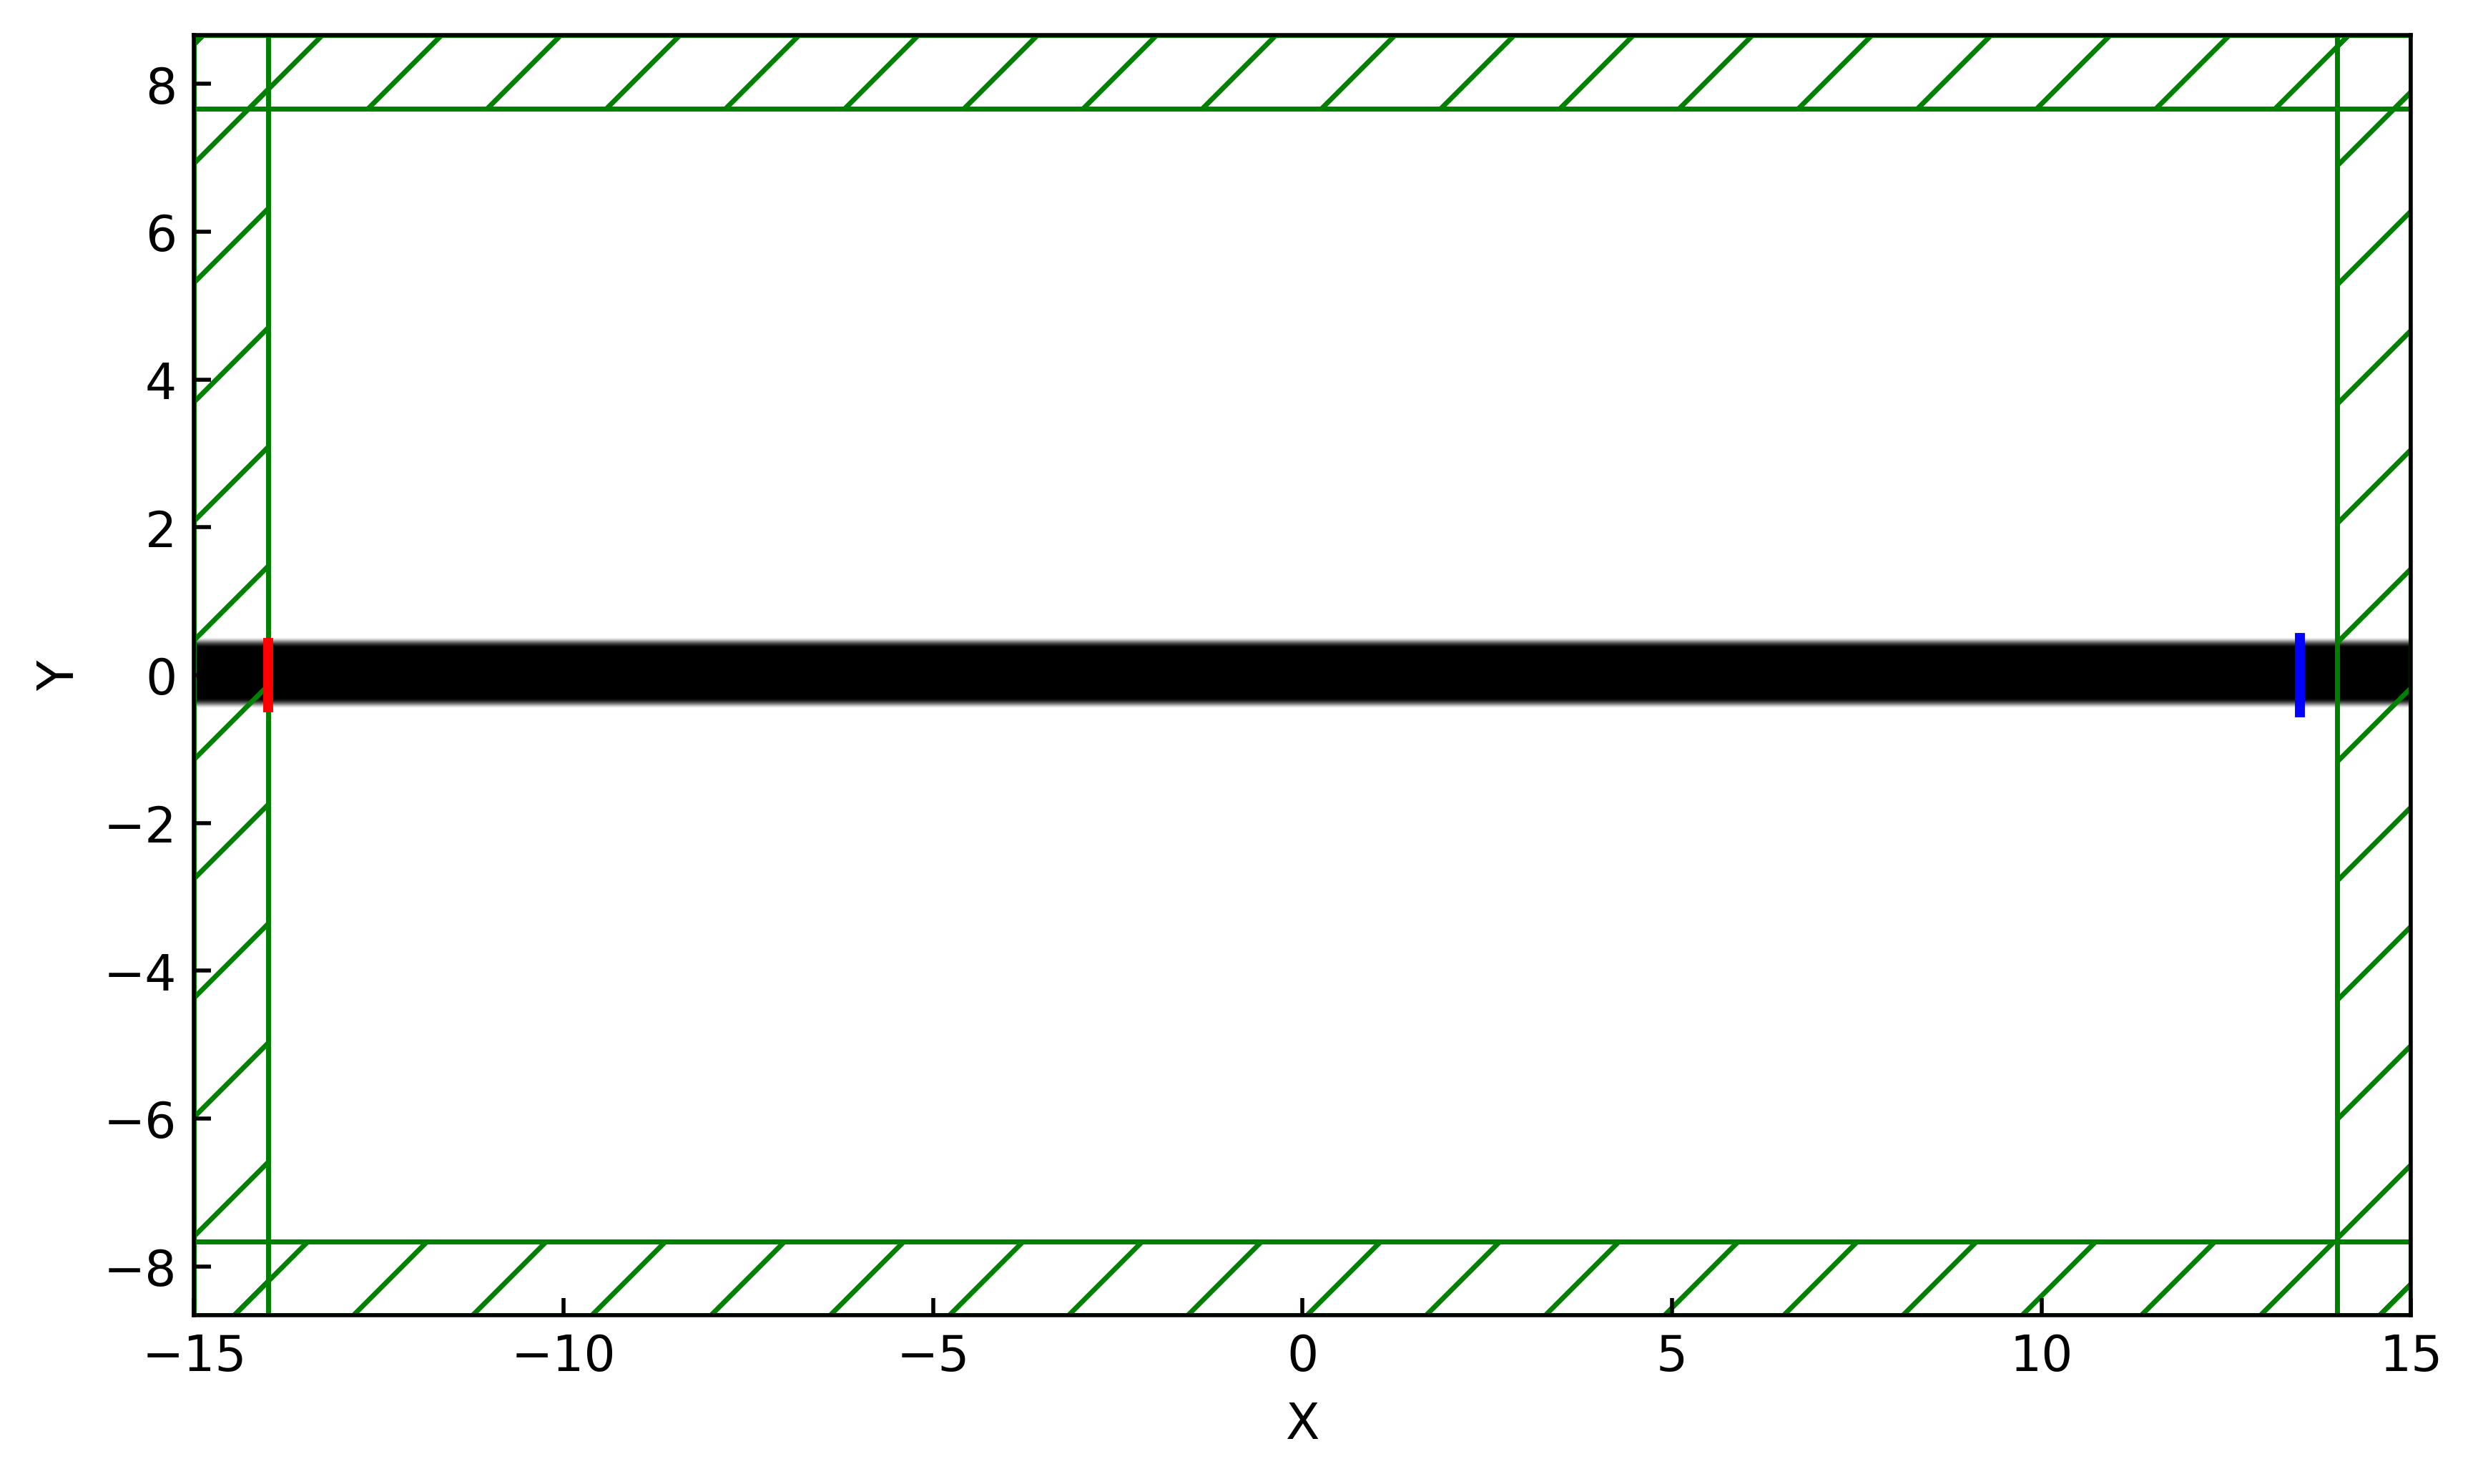

FloatProgress(value=0.0, description='0% done ', max=500.0)

Meep progress: 56.1875/500.0 = 11.2% done in 4.0s, 31.6s to go
on time step 1799 (time=56.2188), 0.00222397 s/step
Meep progress: 113.5/500.0 = 22.7% done in 8.0s, 27.3s to go
on time step 3636 (time=113.625), 0.0021793 s/step
Meep progress: 168.53125/500.0 = 33.7% done in 12.0s, 23.6s to go
on time step 5396 (time=168.625), 0.0022729 s/step
Meep progress: 211.71875/500.0 = 42.3% done in 16.0s, 21.8s to go
on time step 6780 (time=211.875), 0.00289107 s/step
Meep progress: 249.96875/500.0 = 50.0% done in 20.0s, 20.0s to go
on time step 8003 (time=250.094), 0.00327171 s/step
Meep progress: 303.25/500.0 = 60.6% done in 24.0s, 15.6s to go
on time step 9708 (time=303.375), 0.00234637 s/step
Meep progress: 348.375/500.0 = 69.7% done in 28.0s, 12.2s to go
on time step 11154 (time=348.562), 0.00276664 s/step
Meep progress: 367.75/500.0 = 73.5% done in 32.0s, 11.5s to go
on time step 11769 (time=367.781), 0.00650526 s/step
Meep progress: 385.0625/500.0 = 77.0% done in 36.0s, 10.8s to go
on time

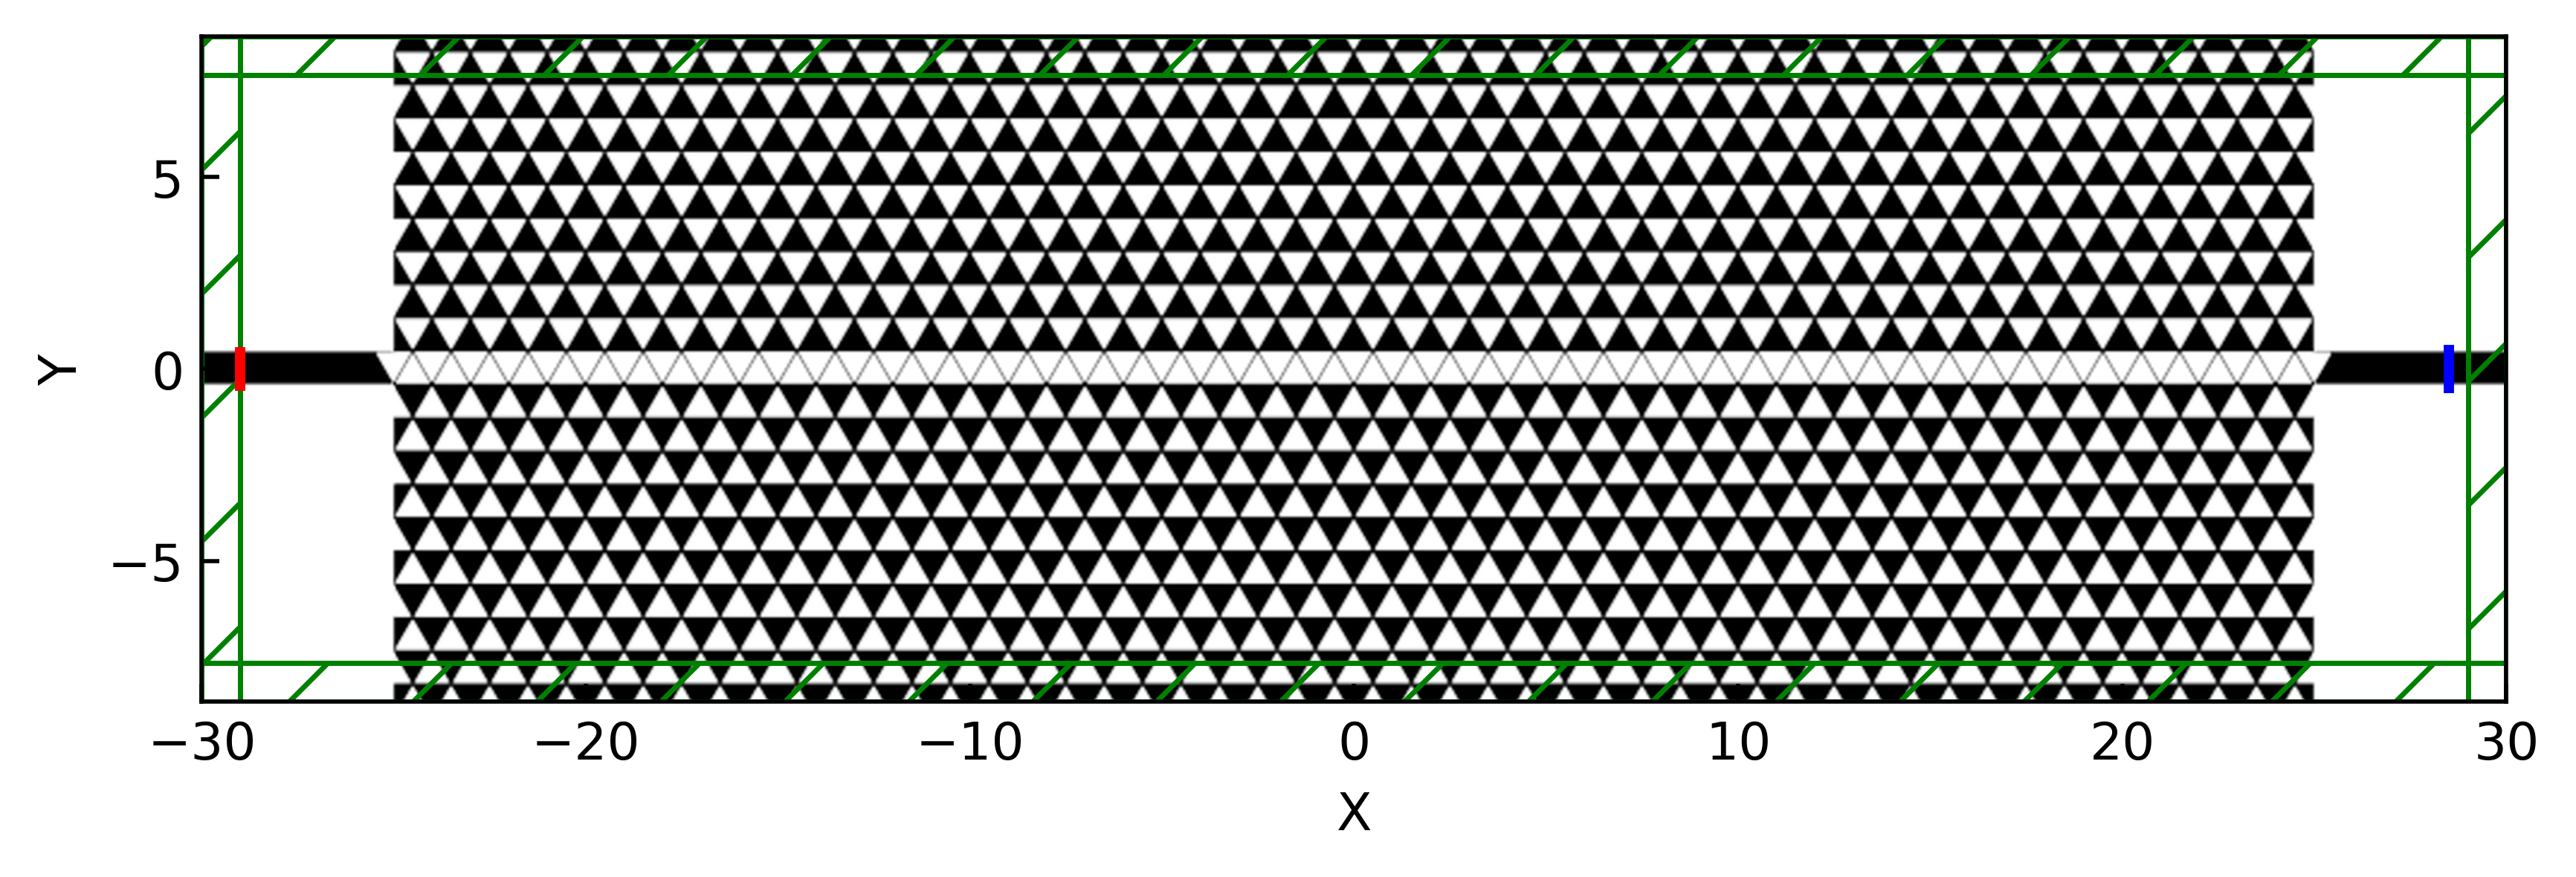

FloatProgress(value=0.0, description='0% done ', max=10000.0)

ress: 6702.71875/10000.0 = 67.0% done in 1561.6s, 768.2s to go
on time step 214621 (time=6706.91), 0.00742447 s/step
Meep progress: 6721.875/10000.0 = 67.2% done in 1565.6s, 763.5s to go
on time step 215226 (time=6725.81), 0.00661566 s/step
Meep progress: 6738.71875/10000.0 = 67.4% done in 1569.6s, 759.6s to go
on time step 215780 (time=6743.12), 0.00722215 s/step
Meep progress: 6759.125/10000.0 = 67.6% done in 1573.6s, 754.5s to go
on time step 216430 (time=6763.44), 0.0061618 s/step
Meep progress: 6779.0625/10000.0 = 67.8% done in 1577.6s, 749.6s to go
on time step 217077 (time=6783.66), 0.00618862 s/step
Meep progress: 6799.4375/10000.0 = 68.0% done in 1581.6s, 744.5s to go
on time step 217727 (time=6803.97), 0.00615516 s/step
Meep progress: 6816.78125/10000.0 = 68.2% done in 1585.6s, 740.4s to go
on time step 218275 (time=6821.09), 0.00730003 s/step
Meep progress: 6834.3125/10000.0 = 68.3% done in 1589.6s, 736.3s to go
on time step 218759 (time=6836.22), 0.0082677 s/step
Meep progr

In [4]:
freqs_wo, psd_out_wo = phc_trans(PhC = False, lengthPhC = 20, decay_check=10, T_decay=500)
freqs_w,  psd_out_w  = phc_trans(PhC = True, lengthPhC = 50, decay_check=20, T_decay=10000)

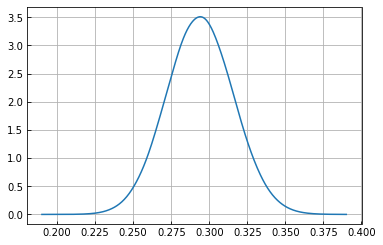

In [5]:
plt.plot(freqs_wo,psd_out_wo)
plt.grid(True)

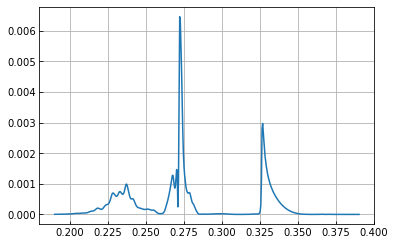

In [6]:
plt.plot(freqs_w,psd_out_w)
plt.grid(True)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


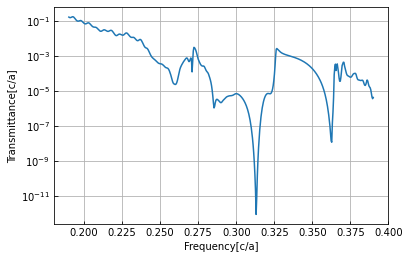

In [7]:
plt.plot(np.array(freqs_w), np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.yscale('log')
plt.grid(True)

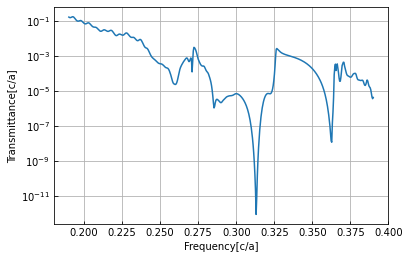

In [8]:
plt.plot(np.array(freqs_w), np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.yscale('log')
plt.grid(True)

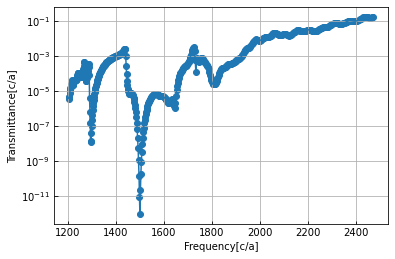

In [9]:
a = 470
c_const = 299792458

freqs = a / np.array(freqs_w)
#freqs
plt.plot(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.scatter(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
#plt.xlim([0.28,0.30])
plt.yscale('log')
plt.grid(True)

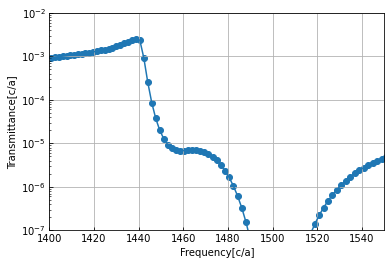

In [10]:
freqs = a / np.array(freqs_w)
#freqs
plt.plot(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.scatter(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.xlim([1400,1550])
plt.yscale('log')
plt.ylim([1e-7,1e-2])
plt.grid(True)

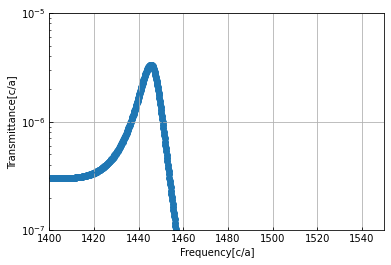

In [13]:
freqs = a / np.array(freqs_w)
#freqs
plt.plot(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.scatter(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.xlim([1400,1550])
plt.yscale('log')
plt.ylim([1e-7,1e-5])
plt.grid(True)

In [13]:
df = pd.DataFrame()
df["wavelength"] = freqs
df["transmittance"] = np.array(psd_out_w)/np.array(psd_out_wo)
df.to_csv("210122_resolution16_waveguide_VPhCtriangle_bearded_adiabatic_transmittance_d090_uasq34b_km025both.ipynb")

In [13]:
df

,wavelength,transmittance
0,2350.000000,0.075326
1,2349.530000,0.075350
2,2349.060188,0.075379
3,2348.590564,0.075425
4,2348.121127,0.075477
...,...,...
4995,1175.470282,0.093933
4996,1175.352676,0.094882
4997,1175.235094,0.095807
4998,1175.117535,0.096707
